# Compute the Structure Factor and Boson Entropy from the Pair Correlation Function After a Quench

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from collections import defaultdict
import pickle

import include.colors as colortools

style_file = './include/sf.mplstyle'
with plt.style.context(style_file):
    fig_size = plt.rcParams['figure.figsize'] 

### Load useful utilities from disk

In [2]:
import quenchutils as quench

## Load ED data from disk and compute the pair correlation function

Using the notation in Appendix A4 in Giuliani and Vignale "Quantum Theory of the Electron Liquid" on Page 682 Eq. (A4.2) we define:

\begin{equation}
g_2(i-j) = \frac{\langle \hat{n}_i \hat{n}_j \rangle}{\rho_0^2} - \frac{\delta_{i,j}}{\rho_0}
\end{equation}

where $ \rho_0$  is the density.

In [116]:
g2,g2_eq = {},{}

Vi = 0.0
Vf = [-0.5,-0.25,-0.15,0.15,0.25,0.765]
Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
Δt = 0.1
ti = 0.0
ρ = 0.5  # 1/2 filling in units where the lattice spacing is unity
kF = π*ρ # Fermi wavevector

kFN = {}

N = np.arange(4,14)
N_even = np.arange(4,14,2)
N_odd = np.arange(5,14,2)
    
cn = 1
bc = 'PBC'
colors = colortools.get_linear_colors('Spectral',len(Vf),reverse=False)

# Get Equilbrium Results First
ti,tf = 0.0,0.0
for cVf in Vf:
    Vi = cVf
    for i,cN in enumerate(N):
        data_dir = '../data/equilibrium/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            g2_eq[key] = p_data[1:]
            g2_eq[key] /= ρ**2
            g2_eq[key][0] -= 1/ρ
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

# Load the quench results from disk
Vi = 0.0
ti,tf = 0.0,100.0
for cVf in Vf:
    for i,cN in enumerate(N):
        data_dir = f'../data/quench/ED/{bc:s}/'
        try:
            p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2'))
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)
            g2[key] = p_data
            g2[key][:,1:] /= ρ**2
            g2[key][:,1] = g2[key][:,1] - 1/ρ
            
            if not cN % 2:
                kFN[key] = π/2
            else:
                kFN[key] = π*(cN-1)/(2*cN)
        except:
            print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='g2')))

## The Structure Factor

In order to obtain the Fourier components of the density fluctuation operator we express things in terms of the static structure factor $s(q)$ defined by:

\begin{equation}
s(q;t) = 1 + f\sum_{x=0}^{L/2-1} \left[g_2(x;t)-1 \right] \mathrm{e}^{-i q x}
\end{equation}

where $f = \rho_0 a_0$ is the filling fraction with $a_0$ the lattice spacing (set to unity here).  

Let us investigate it's time dependence re-scaled by the ground state LL prediction $S_{LL}(q) = K \frac{|q|}{2k_{\rm F}}$ where we evaluate the Luttinger paramger $K$ via the Bethe ansatz 

\begin{equation}
K = \frac{\pi}{2\cos^{-1}(-V/2J)}
\end{equation}




In [5]:
S_eq = {}
q_eq = {}
n_eq = {}

for iV,cVf in enumerate(Vf):
    for cN in N:
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        
        x = np.arange(2*cN)
        Δx = x[1]-x[0]
        q_eq[key_eq] = 2*π*np.fft.rfftfreq(x.size,Δx)
        q_eq[key_eq][0] = 1E-16

        # Equilibrium Structure factor
        S_eq[key_eq] = (1.0 + ρ*np.fft.rfft(g2_eq[key_eq]-1)).real
        S_eq[key_eq][0] = 1E-16

### Investigate the finite size scaling of the equilibrium structure factor

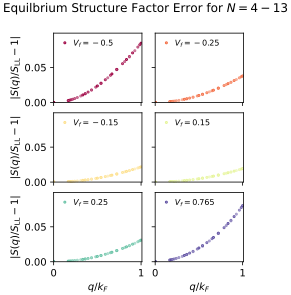

In [6]:
fig, axes = plt.subplots(3,2,sharex=True, sharey=True, squeeze=True, figsize=(fig_size[0],2*fig_size[1]))
axes = axes.flatten()

for iV,cVf in enumerate(Vf):
    
    K = quench.KV(cVf)

    for cN in N[:]:
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc=bc)

        col = colortools.get_alpha_hex(colors[iV],cN/np.max(N))
        props = {'mec':col,'mew':1.0, 'ls':'None','ms':2,
                 'mfc':colortools.get_alpha_hex(colors[iV],0.5), 'color':col, 'lw':1.0}
        
        if key_eq in q_eq:
            SLL_analytical = K*np.abs(q_eq[key_eq])/(2.0*kF)
            SLL_analytical[0] = S_eq[key_eq][0].real
            if cN == N[-1]:
                label = f'$V_f = {cVf}$'
            else:
                label = ''
            
            ΔS_eq = np.abs((S_eq[key_eq].real-SLL_analytical)/SLL_analytical)
            axes[iV].plot(q_eq[key_eq]/kFN[key],ΔS_eq, marker='o',label=label, **props)

        # Axis Labels 
        if not iV % 2:
            axes[iV].set_ylabel(r'$|S(q)/S_{\rm LL}-1|$')

        if iV >3:
            axes[iV].set_xlabel(r'$q/k_F$')
         
        
    axes[iV].legend(frameon=False, fontsize=8, handletextpad=0.05, loc=(0.0,0.75))

axes[0].set_xlim(0,1.01)
axes[0].set_ylim(0,0.099)
fig.subplots_adjust(hspace=0.15, wspace=0.15)
fig.suptitle('Equilbrium Structure Factor Error for $N=4-13$');

### Normalize the time dependent structure factor by its equilibrium value

In [337]:
S̄ = defaultdict(list)
q = {}

for iV,cVf in enumerate(Vf):
    K = quench.KV(cVf)
    
    for cN in N:
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        
        if key in g2:

            x = np.arange(2*cN)
            Δx = x[1]-x[0]
            q[key] = 2*π*np.fft.rfftfreq(x.size,Δx)
            q[key][0] = 1E-16
            
            SLL_analytical = K*np.abs(q[key])/(2.0*kF) 
            
            # here we use the empirical (measured) value
            SLL = S_eq[key_eq]
        
            len_t = len(g2[key][:,0])
            for it in range(len_t):
                S̄[key].append((1.0 + ρ*np.fft.rfft(g2[key][it,1:]-1.0).real)/SLL)
                
            S̄[key] = np.array(S̄[key])
            
#             _t = g2[key][:,0]
#             p = np.polyfit(_t,S̄[key][:,1],1)
#             fp = np.poly1d(p)
            
#             for i in range(1,S̄[key].shape[1]):
#                 S̄[key][:,i] = S̄[key][:,i] - fp(_t)
            

### Examining the Structure Factor at Short Times $t \cdot J = 1/2$ for $N = 13$

Text(0.5, 0, '$q/k_{\\rm F}$')

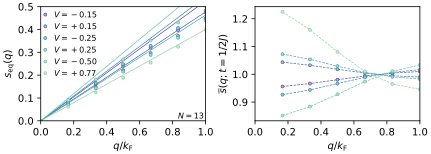

In [11]:
ncolors = colortools.get_linear_colors('Spectral',20,reverse=True)
fig, axes = plt.subplots(1,2,sharex=True, sharey=False, squeeze=True, figsize=(2*fig_size[0],fig_size[1]))
fig.subplots_adjust(wspace=0.3)

q_th = np.linspace(0,2,1000)
for iV,cVf in enumerate(Vp):

    for cN in N[-1:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc='PBC')
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc='PBC')

        props = {'mec':ncolors[iV],'mew':0.7,'ms':3,
                 'mfc':colortools.get_alpha_hex(ncolors[iV],0.5), 'color':ncolors[iV], 'lw':0.7}
        
        if key_eq in q_eq:
            axes[0].plot(q_eq[key_eq]/kFN[key],S_eq[key_eq].real, marker='o', label=f'$V = {cVf:+.2f}$', ls='None', **props)
            
            ## The LL Prediction
            K = quench.KV(cVf)
            axes[0].plot(q_th,K*q_th/(2.0), lw=0.7,color=ncolors[iV], linestyle='-', zorder=-1)
        
        
        if key in S̄:
            idx = np.where(np.abs(g2[key][:,0]-1/2)<Δt)[0][0]
            axes[1].plot(q[key][1:]/kFN[key],S̄[key][idx,1:], marker='o', label=f'$V_f = {cVf:+.2f}$', linestyle='--',**props)

axes[0].text(0.99,0.02,f'$N = {cN}$',transform=axes[0].transAxes, fontsize=8, ha='right')
axes[0].set_xlabel(r'$q/k_{\rm F}$')
axes[0].set_ylabel(r'$s_{\rm eq}(q)$')
axes[0].legend(loc=(-0.04,0.35),frameon=False, fontsize=8, handletextpad=0.1)
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,0.5)

axes[1].set_ylabel(r'$\overline{s}(q;t= 1/2J)$')
axes[1].set_xlabel(r'$q/k_{\rm F}$')

#plt.savefig('Output/Sq_vs_q_N_13.pdf')

### Comparison of Pre and Post Quench Structure Factor

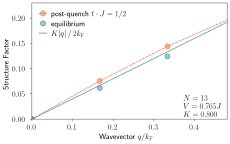

In [14]:
ncolors = colortools.get_linear_colors('Spectral',20,reverse=True)
Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
blue = "#4b90a5"
orange = "#f67a49"

plt.style.reload_library()
with plt.style.context(style_file):
    fig, axes = plt.subplots(1,1,)

    q_th = np.linspace(0,2,1000)
    iV = 5
    cVf = 0.765
    cN = 13
    key = quench.lookup(cN,Vi,cVf,Δt,cn,bc='PBC')
    key_eq = quench.lookup(cN,cVf,cVf,Δt,cn,bc='PBC')
        
    if key in S̄:
        idx = np.where(np.abs(g2[key][:,0]-1/2)<Δt)[0][0]
        idx = 4
        axes.plot(q[key]/kFN[key],S̄[key][idx,:]*S_eq[key_eq], marker='o', label=r'post-quench  $t \cdot J = 1/2$', linestyle='--', 
                  mfc=orange+'80',mec=orange, mew=0.7, ms=5, color=orange, lw=0.7)
        
    if key_eq in q_eq:
        axes.plot(q_eq[key_eq]/kFN[key],S_eq[key_eq].real, marker='o', label='equilibrium', ls='None', mec=blue, 
                  mfc=blue+'80', ms=5, mew=0.7)
            
        ## The LL Prediction
        K = quench.KV(cVf)
        axes.plot(q_th,K*q_th/(2.0), lw=0.7,color=blue, linestyle='-', zorder=-1, label=r'$ {K|q|}\, /\,  {2k_{\rm F}} $')

    #lab = f'$N = {cN}$' + '\n' + f'$V = {cVf:.3f}J$' + '\n' f'$K = {K:.3f}$'
    lab = f'$N = {cN}$      ' + '\n' + f'$V = {cVf:.3f}J$' + '\n' f'$K = {K:.3f}$ '

    axes.text(0.775,0.02,lab,transform=axes.transAxes, fontsize=8, ha='left')
    axes.set_xlabel(r'Wavevector  $q/k_{\rm F}$')
    axes.set_ylabel(r'Structure Factor')
    axes.legend(loc='upper left',frameon=False, fontsize=8, handletextpad=0.5, handlelength=1)
    axes.set_xlim(0,0.48)
    axes.set_ylim(0,0.23)

    plt.savefig(f'../figures/S_vs_q_N_{cN}.pdf')
    plt.savefig(f'../figures/S_vs_q_n_{cN}.svg')

## Extracting the boson momentum distribution at low-$q$

We want to investigate fitting the time dependence of the low-q structure factor to the Luttinger liquid prediction:

\begin{equation}
\bar{s}(q; t) \equiv \frac{s(q; t)}{K |q|/(2k_{\rm F})}  =    2 n(q) + 1 + \cos(2 \omega_q t) \sinh(2 \beta) 
\end{equation}

and we will perform a 3 paramter fit to $n_{\rm LL}$, $C$ and $\omega_q$ via

\begin{equation}
\bar{s}(q; t) = 1 + 2 n_{\rm LL} + C \cos(2 \omega_q t)\; .
\end{equation}

In [338]:
from lmfit import minimize, Parameters

def get_fit(x,y,nLL,C,ω):
    fit_params = Parameters()
    fit_params.add('nLL', value=nLL, min=0.0, max=1.0, vary=True)
    fit_params.add('C', value=C, min=-1.0, max=1.0, vary=True)
    fit_params.add('omega', value=ω, min=0.0, vary=True)
    
    # Note: we don't vary the c1 parameter, it was inserted for testing
    # of a time dependent growth factor.
    fit_params.add('c1',value=0.0, vary=True)

    def f(params,x_):
        p = {}
        [p.update({pname:params[pname].value}) for pname in ['nLL','C','c1','omega']]
        return 1.0 + 2*p['nLL'] + p['c1']*x_ + p['C']*np.cos(2*p['omega']*x_)
        
    def fss_residual(params, x_, y_):
        return f(params,x_) - y_
    
    fit = minimize(fss_residual, fit_params, args=(x,y))    
    
    return lambda x: f(fit.params,x),fit

def S̄LL(params,x_):
    p = {}
    [p.update({pname:params[pname].value}) for pname in ['nLL','C','c1','omega']]
    return 1.0 + 2*p['nLL'] + p['c1']*x_ + p['C']*np.cos(2*p['omega']*x_)

### Fit to the expected form of the short-time structure factor

We do this for each interaction strength and each value of system size $N$

In [342]:
S_fit_par = defaultdict(list)
nq_fit, Δnq_fit = defaultdict(list),defaultdict(list)
kF_index = {}

S_from_nq, ΔS_from_nq = {},{}

S_fss_even,S_fss_odd = defaultdict(list),defaultdict(list)
ΔS_fss_even,ΔS_fss_odd = defaultdict(list),defaultdict(list)

S_fss,ΔS_fss = defaultdict(list),defaultdict(list)

for iV,cVf in enumerate(Vf):
    K = quench.KV(cVf)
    Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
    
    for cN in N:
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        key_eq = quench.lookup(cN,cVf,cVf,Δt,cn)
        K = quench.KV(cVf)
        
        # we find the q_vectors < kF
        kF_index[key] = np.where(q[key]>=kFN[key])[0][0]
        
        if key in S̄:
            for q_index,cq in enumerate(q[key]):
                
                #get the time dependent n(q,t) data and perform a fit
                data = S̄[key][:,q_index]
                t = g2[key][:,0]*quench.tscalefactor(cVf)
                
                nLL0 = (K+1/K-2)/4.0 
                C0 = np.abs(1/K-K)/2 
                ω0 = q[key][q_index]
                
                if cq >= kFN[key]:
                    stop_fit = 4
                else:
                    stop_fit = int(np.where(np.abs(g2[key][:,0]*quench.tscalefactor(cVf)-cN/2)<Δt*quench.tscalefactor(cVf))[0][0])
                    
                #stop_fit = 8
                
                fit_n,fit = get_fit(t[:stop_fit],data[:stop_fit],nLL0,C0,ω0)
                
                # store all fit parameters and the values of nq
                S_fit_par[key].append(fit) 
                nq_fit[key].append(fit.params['nLL'].value)
                if fit.params['nLL'].stderr is not None:
                    Δnq_fit[key].append(fit.params['nLL'].stderr)
                else:
                    Δnq_fit[key].append(fit.params['nLL'].value)              
        
            # turn our arrays into numpy arrays
            nq_fit[key] = np.array(nq_fit[key])
            Δnq_fit[key] = np.array(Δnq_fit[key])
            
            # we get all values q>0 and q <= kF
            stop = kF_index[key] + 1
            _nq = nq_fit[key][1:stop]
            _Δnq = Δnq_fit[key][1:stop]
            
            # we do some simple error propagation to estimate the error
            # in the entropy
            Δln_nq = _Δnq/_nq
            Δlnp_nq = _Δnq/(1+_nq)
            Δprod_p2 = (_nq*np.log(_nq))**2 * ( (_Δnq/_nq)**2 + (Δln_nq/np.log(_nq))**2 )
            Δprod_m2 = ((1+_nq)*np.log(1+_nq))**2 * ( (_Δnq/(1+_nq))**2 + (Δlnp_nq/np.log(1+_nq))**2 )
                        
            ΔS_from_nq[key] = (2.0/cN)*np.sqrt(np.sum(Δprod_p2 + Δprod_m2))
            S_from_nq[key] = (-2/cN)*np.sum(_nq*np.log(_nq) - (1+_nq)*np.log(1+_nq))
            
            if False:
                if cN % 2:
                    S_from_nq[key] += (-1/cN)*np.sum(nq_fit[key][stop]*np.log(nq_fit[key][stop]) - (1+nq_fit[key][stop])*np.log(1+nq_fit[key][stop]))
                
            
            S_fss[Vkey].append(S_from_nq[key])
            ΔS_fss[Vkey].append(ΔS_from_nq[key])
            
            if cN % 2:
                S_fss_odd[Vkey].append(S_from_nq[key])
                ΔS_fss_odd[Vkey].append(ΔS_from_nq[key])
            else:
                cS = (-1)*(np.sum(_nq*np.log(_nq) - (1+_nq)*np.log(1+_nq)) + np.sum(_nq[:-1]*np.log(_nq[:-1]) - (1+_nq[:-1])*np.log(1+_nq[:-1])))/cN
                #S_from_nq[key]
                S_fss_even[Vkey].append(cS)
                ΔS_fss_even[Vkey].append(ΔS_from_nq[key])
    
    S_fss[Vkey] = np.array(S_fss[Vkey])
    ΔS_fss[Vkey] = np.array(ΔS_fss[Vkey])
    
    S_fss_odd[Vkey] = np.array(S_fss_odd[Vkey]) 
    ΔS_fss_odd[Vkey] = np.array(ΔS_fss_odd[Vkey])
    S_fss_even[Vkey] = np.array(S_fss_even[Vkey])
    ΔS_fss_even[Vkey] = np.array(ΔS_fss_even[Vkey])

### Visually investigate the fitting for each system size

Here one needs to manually set `cN` and `q_index`

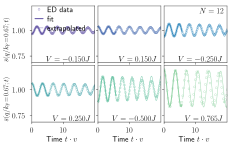

In [343]:
with plt.style.context(style_file):
    fig_size = plt.rcParams['figure.figsize']
    dfig_size = (1.5*fig_size[0],1.5*fig_size[1])
    ncolors = colortools.get_linear_colors('Spectral',2*len(N),reverse=True)

    fig, axes = plt.subplots(2,3,sharex=True, sharey=True, squeeze=True)
    axes = axes.flatten()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    cN = 12

    Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
    for iV,cVf in enumerate(Vp):

        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        
        q_index = kF_index[key]-2
        K = quench.KV(cVf)
        if key in S_fit_par:

            data = S̄[key][:,q_index]
            t = g2[key][:,0]*quench.tscalefactor(cVf)
            stop_fit = int(np.where(np.abs(g2[key][:,0]*quench.tscalefactor(cVf)-cN/2)<Δt*quench.tscalefactor(cVf))[0][0]/(1))
            
            props = {'mec':ncolors[iV],'mew':0.25, 'ls':'None','ms':2, 'mfc':'None'}
            axes[iV].plot(t,data, 'o', **props, label='ED data')
            
            axes[iV].plot(t[:stop_fit],S̄LL(S_fit_par[key][q_index].params,t[:stop_fit]),'-', color=ncolors[iV], linewidth=1, label=r'fit')
            axes[iV].plot(t[stop_fit:],S̄LL(S_fit_par[key][q_index].params,t[stop_fit:]),'-', color=colortools.get_alpha_hex(ncolors[iV],0.8), 
                          linewidth=0.5, label=r'extrapolated')

            if not iV % 3:
                cq = q[key][q_index]/kFN[key]
                axes[iV].set_ylabel(r'$\bar{{s}}(q/k_{{\rm F}}\!=\!{:3.2f};t)$'.format(cq), fontsize=7)
            axes[iV].set_xlim(0,20)
            axes[iV].text(0.99,0.02,'$V = {:5.3f}J$'.format(cVf),transform=axes[iV].transAxes, fontsize=8, ha='right')

    axes[2].text(0.99,0.87,f'$N = {cN}$',transform=axes[2].transAxes, fontsize=8, ha='right')
    axes[0].legend(loc=(0.0,0.48), fontsize=8, handlelength=1, labelspacing=0.2, handletextpad=0.5)
    for iax in range(-3,0):
        axes[iax].set_xlabel(r'Time  $t \cdot v$')

    #axes[-1].set_ylim(0.79,1.29)
    axes[-1].set_xlim(0,19.9)

#    plt.savefig(f'../figures/nqt_vs_t_with_fit_N_{cN}.svg')
#    plt.savefig(f'../figures/nqt_vs_t_with_fit_N_{cN}.pdf')

## Investigate $n(q)$ vs. $q$ for different interactions and system sizes

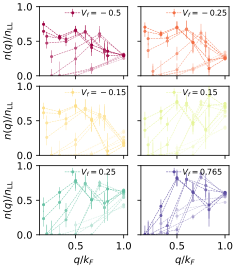

In [330]:
fig, axes = plt.subplots(3,2,sharex=True, sharey=True, squeeze=True, figsize=(fig_size[0],2*fig_size[1]))
axes = axes.flatten()

for iV,cVf in enumerate(Vf):
    
    K = quench.KV(cVf)
    n0 = 0.25*(K+1/K-2)

    for cN in N[:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)

        col = colortools.get_alpha_hex(colors[iV],cN/np.max(N))
        props = {'mec':col,'mew':1.0, 'ls':'--','ms':2, 'marker':'o', 'ecolor':col,
                 'mfc':col, 'color':col, 'lw':0.5, 'elinewidth':0.5}
        
        if key in nq_fit:
            kF_idx = kF_index[key]+1

            if cN == N[-1]:
                label = f'$V_f = {cVf}$'
            else:
                label = ''
                
            
            axes[iV].errorbar(q[key][1:kF_idx]/kFN[key],nq_fit[key][1:kF_idx]/n0, yerr=Δnq_fit[key][1:kF_idx]/n0,label=label, **props)
            
            #S_eq = np.abs((S_eq[key_eq].real-SLL_analytical)/SLL_analytical)
            #axes[iV].plot(q_eq[key_eq]/kF,ΔS_eq, marker='o',label=label, **props)

        # Axis Labels 
        if not iV % 2:
            axes[iV].set_ylabel(r'$n(q)/n_{\rm LL}$')

        if iV >3:
            axes[iV].set_xlabel(r'$q/k_F$')
         
        
    axes[iV].legend(frameon=False, fontsize=8, handletextpad=0.05, loc=(0.25,0.8))

#axes[0].set_xlim(0,1.01)
axes[0].set_ylim(0,1)
fig.subplots_adjust(hspace=0.15, wspace=0.15)
#fig.suptitle('Equilbrium Structure Factor Error for $N=4-13$');

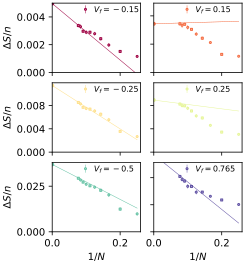

In [326]:
fig, axes = plt.subplots(3,2,sharex=True, sharey=False, squeeze=True, figsize=(fig_size[0],2*fig_size[1]))
axes = axes.flatten()

invN_fit = np.linspace(0,0.25,100)
#invlnN_fit = np.linspace(0,0.25,100)

extrap_Sb,Δextrap_Sb = {},{}

for iV,cVf in enumerate(Vp):
    
    K = quench.KV(cVf)
    n0 = 0.25*(K+1/K-2)
    
    Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
    props = {'mec':colors[iV],'mew':1.0, 'ls':'None','ms':2, 'ecolor':colors[iV],
                 'mfc':colortools.get_alpha_hex(colors[iV],0.5), 'color':col, 'lw':0.5, 'elinewidth':0.5}
    
    even = False
    fit_start = -4
    
    if not even:
        fit_var = np.log(N[fit_start:])/N[fit_start:]
        fit_var = 1/N[fit_start:]
        fit_data = S_fss[Vkey][fit_start:]
    else:
        fit_var = 1/N_even[fit_start:]
        fit_data = S_fss_even[Vkey][fit_start:]
    
    try:
        p,Δp = np.polyfit(fit_var,fit_data,1,cov=True)
        Δp = np.sqrt(Δp[1,1])
    except:
        p = np.polyfit(fit_var,fit_data,1,cov=False)
        Δp = 0.0
        
    
    extrap_Sb[Vkey] = p[1]
    Δextrap_Sb[Vkey] = Δp
    
    
    axes[iV].plot(0,p[-1], 'o', color=colors[iV], ms=3)
    axes[iV].plot(invN_fit,np.poly1d(p)(invN_fit),'-',color=colors[iV], lw=0.5)
    #axes[iV].errorbar(1/N,S_fss[Vkey], yerr=ΔS_fss[Vkey], **props, label=f'$V_f = {cVf}$')
    axes[iV].errorbar(1/N_even,S_fss_even[Vkey], yerr=ΔS_fss_even[Vkey], **props, marker='o', label=f'$V_f = {cVf}$')
    axes[iV].errorbar(1/N_odd,S_fss_odd[Vkey], yerr=ΔS_fss_odd[Vkey], **props, marker='s')


    #p,Δp = np.polyfit(1/N_even[fit_start:],S_fss_even[Vkey][fit_start:],1,cov=True)
    #p = np.polyfit(1/N_even[fit_start:],S_fss_even[Vkey][fit_start:],1)
    #axes[iV].plot(0,p[-1], 'o',color=colors[iV], ms=3)
    #axes[iV].plot(invN_fit,np.poly1d(p)(invN_fit),'-',color=colors[iV], lw=0.5)
    #axes[iV].errorbar(np.log(N_even)/N_even,S_fss_even[Vkey], yerr=ΔS_fss_even[Vkey], **props, label=f'$V_f = {cVf}$')

    # Deal with Axes 
    if iV % 2:
        axes[iV].axes.yaxis.set_ticklabels([])
    else:
        axes[iV].set_ylabel(r'$\Delta S/n$')

    #if iV <4:
    #    axes[iV].axes.xaxis.set_ticklabels([])
         
        
    axes[iV].legend(frameon=False, fontsize=8, handletextpad=0.05, loc=(0.25,0.8))
    
    # manually configure axis
    axes[-2].set_xlabel('$1/N$')
    axes[-1].set_xlabel('$1/N$')
    
    axes[0].set_xlim(0,0.26)
    
    ticks = [0.0,0.004,0.008]
    axes[2].set_yticks(ticks)
    axes[3].set_yticks(ticks)
    
    ticks = [0.0,0.025,0.050]
    axes[4].set_yticks(ticks)
    axes[5].set_yticks(ticks)

    axes[0].set_ylim(0,0.00499)
    axes[1].set_ylim(0,0.0049)
    axes[2].set_ylim(0,0.0119)
    axes[3].set_ylim(0,0.0119)
    axes[4].set_ylim(0,0.038)
    axes[5].set_ylim(0,0.064)
    
    fig.subplots_adjust(hspace=0.15, wspace=0.15)


### Load Spatial Entanglement Data from Disk

In [165]:
with open('../data/S_spatial_TL.pickle', 'rb') as pfile:
    _Vp,See,ΔSee = pickle.load(pfile)
_Vp = np.array(_Vp)

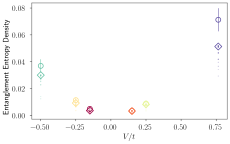

In [327]:
ncolors = colortools.get_linear_colors('Spectral',2*len(N),reverse=True)
ncolors = colors
plt.style.reload_library()
with plt.style.context(style_file):
    for iV,cVf in enumerate(Vp):

        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        plt.errorbar(cVf,extrap_Sb[Vkey],yerr=Δextrap_Sb[Vkey], marker='o', ms=5, mfc='None', mec=ncolors[iV], elinewidth=0.5, ecolor=ncolors[iV],
                    mew=0.75)

        idx = np.where(np.abs(_Vp-cVf)<0.01)[0][0]
        plt.errorbar(_Vp[idx],See[idx],yerr=ΔSee[idx], marker='D', linestyle='None', ms=5, mfc='None', 
                     color=ncolors[iV], mec=ncolors[iV], mew=0.75)

        for cN in N[:]:
            key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)

            col = colortools.get_alpha_hex(ncolors[iV],cN/np.max(N))
            props = {'mec':col,'mew':0.0, 'ls':'--','ms':1, 'marker':'o',
                     'mfc':col, 'color':col, 'lw':0.5}

            K = quench.KV(cVf)

            if key in S_from_nq:
                plt.plot(cVf,S_from_nq[key],**props)        

    plt.xlabel(r'$V/t$')
    plt.ylabel('Entanglement Entropy Density')
    
#    plt.savefig('../figures/entanglement_Sb_fss.pdf')

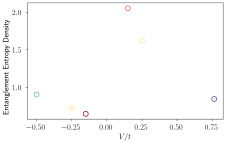

In [320]:
ncolors = colortools.get_linear_colors('Spectral',2*len(N),reverse=True)
ncolors = colors
plt.style.reload_library()
with plt.style.context(style_file):
    for iV,cVf in enumerate(Vp):

        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        idx = np.where(np.abs(_Vp-cVf)<0.01)[0][0]
        plt.errorbar(cVf,extrap_Sb[Vkey]/See[idx],yerr=Δextrap_Sb[Vkey], marker='o', ms=5, mfc='None', mec=ncolors[iV], elinewidth=0.5, ecolor=ncolors[iV],
                    mew=0.75)

        
    plt.xlabel(r'$V/t$')
    plt.ylabel('Entanglement Entropy Density')
    
#    plt.savefig('../figures/entanglement_Sb_fss.pdf')

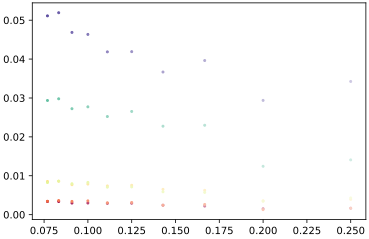

In [244]:
for iV,cVf in enumerate(Vp):
    
    for cN in N[:]:
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)

        col = colortools.get_alpha_hex(colors[iV],cN/np.max(N))
        props = {'mec':col,'mew':1.0, 'ls':'--','ms':2, 'marker':'o',
                 'mfc':col, 'color':col, 'lw':0.5}

        K = quench.KV(cVf)
    
        if key in S_from_nq:
            plt.plot(1/cN,S_from_nq[key],**props)

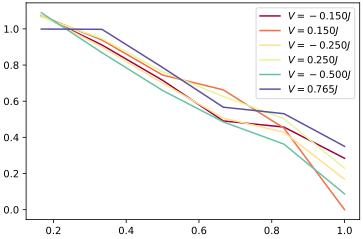

In [117]:
Sb_predict = {}
for iV,cVf in enumerate(Vp):

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    n0 = 0.25*(K+1/K-2)
    if key in S̄:
        plt.plot(q[key][1:7]/kF,S_extracted[key]/n0, label='$V = {:5.3f}J$'.format(cVf), color=colors[iV])
        nq = np.array(S_extracted[key])
        Sb_predict[key] = (-2/cN)*np.sum(nq*np.log(nq) - (1+nq)*np.log(1+nq))
    
    #plt.axhline(y=n0, color=colors[iV], ls='--')
        
plt.legend()

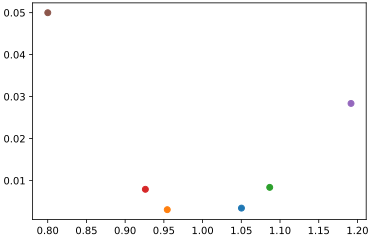

In [118]:
for iV,cVf in enumerate(Vp):

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    if key in S̄:
        plt.plot(K,Sb_predict[key],'o')

In [119]:
with open('../data/Sb_fit.pickle', 'wb') as pfile:
    pickle.dump(Sb_predict, pfile, pickle.HIGHEST_PROTOCOL)

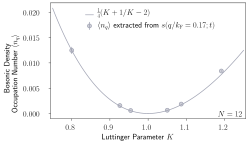

In [18]:
grey = '#9fa2b2'
with plt.style.context(style_file):
    
    fit_K = np.linspace(0.75,1.25,100)
    cN = 12

    props = {'mec':colors[-1],'mew':0.7, 'ecolor':colors[-1], 'elinewidth':0.7, 'ls':'None','ms':4,
                 'mfc':colortools.get_alpha_hex(colors[-1],0.5)+'80'}
    props['mfc'] = grey + '80'
    props['ecolor']=grey
    props['mec'] = grey
    fig, axes = plt.subplots(1,1)

    for iV,cVf in enumerate(Vf):
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        n0 = 0.25*(fit_K+1/fit_K-2)
        if iV == 0:
            cq = q[key][1]/kF
            lab=r'$\langle n_{q} \rangle$ extracted from ' + r'$s(q/k_{{\rm F}}={:.2f};t)$'.format(cq)
        else:
            lab=''
        axes.errorbar(K,Sfit[key].params['nLL'].value,yerr=Sfit[key].params['nLL'].stderr, **props, label=lab, marker='o')

    axes.text(0.99,0.02,f'$N = {cN}$',transform=axes.transAxes, ha='right',fontsize=8)

    axes.plot(fit_K,n0, linewidth=0.7, label=r'$\frac{1}{4}(K+1/K-2)$', color=grey)
    axes.set_xlabel('Luttinger Parameter  $K$')
    axes.set_ylabel('Bosonic Density\n Occupation Number  ' +  r'$\langle n_q \rangle$')
    axes.set_xlim(0.745,1.255)
    axes.legend(handlelength=1)

    plt.savefig(f'../figures/nq_vs_K_with_LL_N_{cN}.svg')
    plt.savefig(f'../figures/nq_vs_K_with_LL_N_{cN}.pdf')

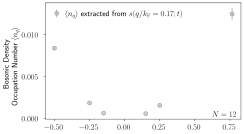

In [19]:
grey = '#9fa2b2'
with plt.style.context(style_file):
    
    fit_K = np.linspace(0.75,1.25,100)
    cN = 12

    props = {'mec':colors[-1],'mew':0.7, 'ecolor':colors[-1], 'elinewidth':0.7, 'ls':'None','ms':4,
                 'mfc':colortools.get_alpha_hex(colors[-1],0.5)+'80'}
    props['mfc'] = grey + '80'
    props['ecolor']=grey
    props['mec'] = grey
    fig, axes = plt.subplots(1,1)

    for iV,cVf in enumerate(Vf):
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        n0 = 0.25*(fit_K+1/fit_K-2)
        if iV == 0:
            cq = q[key][1]/kF
            lab=r'$\langle n_{q} \rangle$ extracted from ' + r'$s(q/k_{{\rm F}}={:.2f};t)$'.format(cq)
        else:
            lab=''
        axes.errorbar(cVf,Sfit[key].params['nLL'].value,yerr=Sfit[key].params['nLL'].stderr, **props, label=lab, marker='o')

    axes.text(0.99,0.02,f'$N = {cN}$',transform=axes.transAxes, ha='right',fontsize=8)

    #axes.plot(fit_K,n0, linewidth=0.7, label=r'$\frac{1}{4}(K+1/K-2)$', color=grey)
    #axes.set_xlabel('Luttinger Parameter  $K$')
    axes.set_ylabel('Bosonic Density\n Occupation Number  ' +  r'$\langle n_q \rangle$')
    #axes.set_xlim(0.745,1.255)
    axes.legend(handlelength=1)

    #plt.savefig(f'../figures/nq_vs_K_with_LL_N_{cN}.svg')
    #plt.savefig(f'../figures/nq_vs_K_with_LL_N_{cN}.pdf')

In [50]:
len(q[key])

13

## Paper Figure 5: Extrating $n(q)$ from $S(q;t)$ 
---

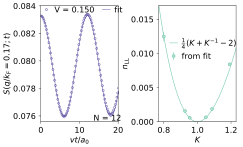

In [20]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(1,2,sharex=False, sharey=False, squeeze=True)
    fig.subplots_adjust(wspace=0.525)
    cVf = 0.15
    cN = 12
    q_index = 1

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    
    # S(q;t) for a single value of V
    
    # get the time dependent S(q,t) data 
    data = S̄[key][:,q_index]
    t = g2[key][:,0]*quench.tscalefactor(cVf)

    props = {'mec':colors[-1],'mew':0.5, 'ls':'None','ms':2, 'mfc':'None'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    SLL = K*np.abs(q[key])/(2.0*kF)
    axes[0].plot(t,data*SLL[q_index], 'o', **props, label=f'V = {cVf:5.3f}')
    axes[0].plot(t,S̄LL(Sfit[key].params,t)*SLL[q_index],'-', color=colors[-1], linewidth=0.5, label=r'fit', zorder=-10)
    axes[0].set_xlabel(r'$vt/a_0$')
    axes[0].set_ylabel(r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(q[key][q_index]/kF))
    axes[0].text(0.68,0.01,f'N = {cN}',transform=axes[0].transAxes, fontsize=8, ha='left')


    axes[0].set_xlim(0,20)
    axes[0].legend(frameon=False, loc=(-0.02,0.9), handletextpad=0.5, handlelength=1.0, ncol=2, columnspacing=1.0)
    
    # n_LL extracted from the fit vs. K
    
    fit_K = np.linspace(0.75,1.25,100)

    props = {'mec':colors[-2],'mew':0.5, 'ecolor':colors[-2], 'elinewidth':0.5, 'ls':'None','ms':3,
                 'mfc':colortools.get_alpha_hex(colors[-2],0.5)}

    for iV,cVf in enumerate(Vf):
        key = quench.lookup(cN,Vi,cVf,Δt,cn)
        K = quench.KV(cVf)
        nLL = 0.25*(fit_K+1/fit_K-2)
        if iV == 0:
            cq = q[key][q_index]/kF
            lab=f'computed from $\bar{{S}}(q/k_{{\rm F}}={cq:.2f};t)$'
            lab = 'from fit'
        else:
            lab=''
        axes[1].errorbar(K,Sfit[key].params['nLL'].value,yerr=Sfit[key].params['nLL'].stderr, **props, label=lab, marker='o')
    
    axes[1].plot(fit_K,nLL,linewidth=0.5, label=r'$\frac{1}{4}(K+K^{-1}-2)$', color=colors[-2])
        
    
    axes[1].legend(frameon=False, loc=(0.1,0.5), handletextpad=0.5, handlelength=1.0, ncol=1, columnspacing=1.0)
    
    axes[1].set_xlabel(r'$K$')
    axes[1].set_ylabel(r'$n_{\rm LL}$')
    axes[1].set_xlim(0.77,1.23)
    axes[1].set_ylim(0,0.017)
    plt.savefig(f'../figures/SqnLL_N{cN}.svg')
    plt.savefig(f'../figures/SqnLL_N{cN}.pdf')

### Save fit data for structure factor to disk

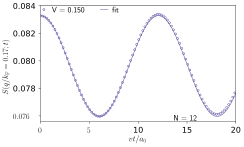

In [19]:
plt.style.reload_library()
with plt.style.context(style_file):

    fig, axes = plt.subplots(1,1,sharex=False, sharey=False, squeeze=True)
    cVf = 0.15
    cN = 12
    q_index = 1

    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    K = quench.KV(cVf)
    
    # S(q;t) for a single value of V
    
    # get the time dependent S(q,t) data 
    data = S̄[key][:,q_index]
    t = g2[key][:,0]*quench.tscalefactor(cVf)

    props = {'mec':colors[-1],'mew':0.5, 'ls':'None','ms':2, 'mfc':'None'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    SLL = K*np.abs(q[key])/(2.0*kF)
    axes.plot(t,data*SLL[q_index], 'o', **props, label=f'V = {cVf:5.3f}')
    axes.plot(t,S̄LL(Sfit[key].params,t)*SLL[q_index],'-', color=colors[-1], linewidth=0.5, label=r'fit', zorder=-10)
    axes.set_xlabel(r'$vt/a_0$')
    axes.set_ylabel(r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(q[key][q_index]/kF))
    axes.text(0.68,0.01,f'N = {cN}',transform=axes.transAxes, fontsize=8, ha='left')

    axes.set_xlim(0,20)
    axes.legend(frameon=False, loc=(-0.02,0.9), handletextpad=0.5, handlelength=1.0, ncol=2, columnspacing=1.0)
    
    # Store everything so we can plot it in another notebook
    structure = {'x1':t,'y1':data*SLL[q_index],'x2':t,'y2':S̄LL(Sfit[key].params,t)*SLL[q_index],'q':q, 'kF':kF}
    
    with open('../figures/Sq_boson_fit.pickle', 'wb') as pfile:
        pickle.dump(structure, pfile, pickle.HIGHEST_PROTOCOL)
    
    #plt.savefig(f'../figures/SqnLL_N{cN}.pdf')